# Breast Cancer Database and FeedForward Neuralnetwork

## 1. Preparations

In [45]:
# Data Processing and Manipulation
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Machine Learning and Neural Networks
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

# Other Tools
import kagglehub


In [47]:
# Import dataset

# Download latest version
path = kagglehub.dataset_download("uciml/breast-cancer-wisconsin-data")

# Combine the directory path and file name 
data_path = os.path.join(path, 'data.csv')  
df = pd.read_csv(data_path)

In [48]:
# Overview of the dataset

## Dataset Dimensions 
rows = df.shape[0] 
cols = df.shape[1] 
print("Rows:", rows)
print("Columns", cols)

## Missing Values
na_info = df.isnull().sum()
na_columns = na_info[na_info > 0]
print("Amount of NA:", na_columns)

## Unique IDs
print("Amount of unique ids:", len(df["id"].unique()))

## Non-Numerical Columns 
non_numerical_columns = df.select_dtypes(exclude = ["number"]).columns
print("Columns with non-numerical values:", non_numerical_columns)

## Dataset Preview 
pd.concat([df.head(2), df.sample(2), df.tail(1)])

Rows: 569
Columns 33
Amount of NA: Unnamed: 32    569
dtype: int64
Amount of unique ids: 569
Columns with non-numerical values: Index(['diagnosis'], dtype='object')


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.26540,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.18600,0.2750,0.08902,NaN
454,911202,B,12.62,17.15,80.62,492.9,0.08583,0.05430,0.02966,0.02272,...,22.15,91.62,633.5,0.12250,0.15170,0.1887,0.09851,0.3270,0.07330,NaN
92,861853,B,13.27,14.76,84.74,551.7,0.07355,0.05055,0.03261,0.02648,...,22.35,104.50,830.6,0.10060,0.12380,0.1350,0.10010,0.2027,0.06206,NaN
568,92751,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.00000,0.2871,0.07039,NaN


In [51]:
# Some data manipulation

## Drop useless variables 
df = df.drop(columns = ["Unnamed: 32", "id"])

## Map diagnosis categories to numeric values: Malignant (M) -> 1, Benign (B) -> 0
df["diagnosis"] = df["diagnosis"].map({"M": 1, "B": 0})

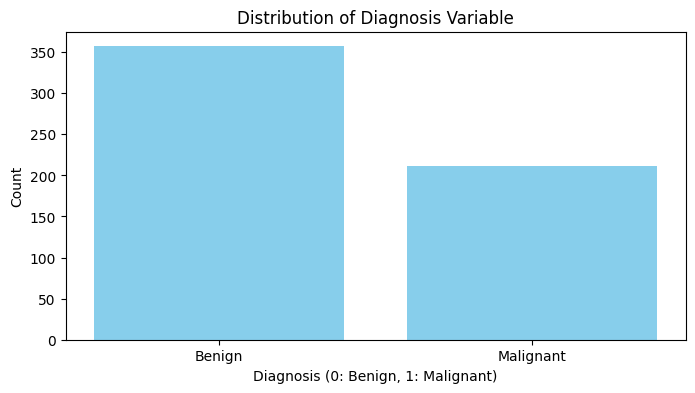

In [53]:
# Quick overview of the dependent variable 

## Get values counts for the diag var
value_counts = df["diagnosis"].value_counts()

## Create a bar plot for the distribution
plt.figure(figsize=(8, 4))
plt.bar(value_counts.index, value_counts.values, color="skyblue", width=0.8)
plt.title("Distribution of Diagnosis Variable")
plt.xlabel("Diagnosis (0: Benign, 1: Malignant)")
plt.ylabel("Count")
plt.xticks(value_counts.index, labels=["Benign", "Malignant"], rotation=0)
plt.show()

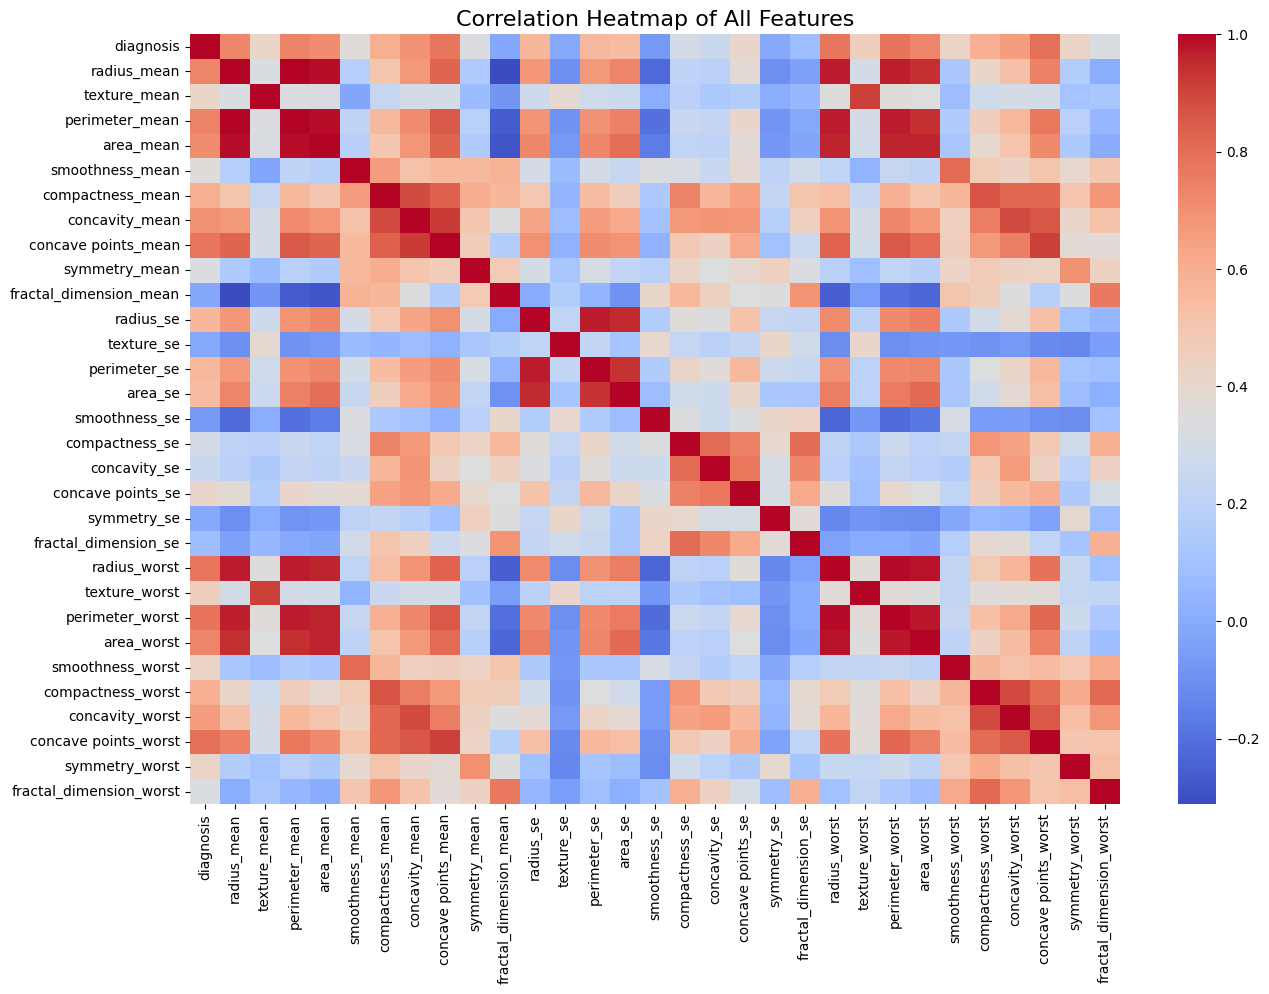

In [55]:
# Correlation heatmap for all features
plt.figure(figsize=(15, 10))  # Adjust the figure size
sns.heatmap(df.corr(), cmap="coolwarm", annot=False, cbar=True)
plt.title("Correlation Heatmap of All Features", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()



In [57]:
# Find Top 5 correlated feature with dependent variable

## Calculate correlation matrix
correlation_matrix = df.corr()
diagnosis_correlation = correlation_matrix["diagnosis"].abs().sort_values(ascending=False)
top_5_features = diagnosis_correlation[1:6] # Exclude 'diagnosis' itself and select the top 5 features
top_5_with_indices = [(df.columns.get_loc(feature), 
                       feature, value) for feature, value in top_5_features.items()] # Add column indices

## Print the results
print("Top 5 features with the highest correlation to 'diagnosis':")
for idx, feature, value in top_5_with_indices:
    print(f"Column Index: {idx}, {feature}, : {value:.4f}")


Top 5 features with the highest correlation to 'diagnosis':
Column Index: 28, concave points_worst, : 0.7936
Column Index: 23, perimeter_worst, : 0.7829
Column Index: 8, concave points_mean, : 0.7766
Column Index: 21, radius_worst, : 0.7765
Column Index: 3, perimeter_mean, : 0.7426


In [59]:
# Preparing data for training 

## Labels and features
X = df.drop(columns = ["diagnosis"])
Y = df["diagnosis"]

## Split into training and test set 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 25)


## Scale the data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data and transform
X_test_scaled = scaler.transform(X_test)       # Transform test data using the same scaler


## Convert pandas DataFrame to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.long)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.long)


## Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=32, # Hyperparameter
                          shuffle=True)



## Print shapes to verify the split
print("Training Set Features Shape:", X_train_tensor.shape)
print("Training Set Labels Shape:", Y_train_tensor.shape)
print("Test Set Features Shape:", X_test_tensor.shape)
print("Test Set Labels Shape:", Y_test_tensor.shape)

Training Set Features Shape: torch.Size([455, 30])
Training Set Labels Shape: torch.Size([455])
Test Set Features Shape: torch.Size([114, 30])
Test Set Labels Shape: torch.Size([114])


## 2. Build the model

In [62]:
# Build the model 

class FeedForward_NN(nn.Module): 

    ## Initialization 
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedForward_NN, self).__init__()
        self.first_layer = nn.Linear(input_size, hidden_size) # First layer
        self.relu = nn.ReLU() # Activationsfunction
        self.second_layer = nn.Linear(hidden_size, num_classes)

    ## Forward Pass
    def forward(self, X):
        out_first_layer = self.first_layer(X)
        out_relu = self.relu(out_first_layer)
        out = self.second_layer(out_relu)
        return out

In [64]:
# Hyperparameter for neural network structure 
input_size = X_train.shape[1]
hidden_size = 10 # number of nodes in hidden layer
num_classes = len(df["diagnosis"].unique()) 
model = FeedForward_NN(input_size, hidden_size, num_classes)


## 3. Train the model

In [67]:
# Setting up hyperparameter for learning
learning_rate = 0.01
num_epochs = 3 # times we go through entire dataset 
criterion = nn.CrossEntropyLoss() # lossfunction 
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # optimizer
n_total_steps = len(train_loader) # for print statement 


In [69]:
# Training loop 

# Loops over entire dataset
for epoch in range(num_epochs):

    # Inner loop over batches 
    for i, (x_batch, y_batch) in enumerate(train_loader):
        
        # Forward pass
        output = model(x_batch)  # Capture model prediction
        loss = criterion(output, y_batch)  # Compute loss
        
        # Backward pass
        optimizer.zero_grad()  # Zero out gradients
        loss.backward()  # Compute gradients using backprop
        optimizer.step()  # Update model parameters
        
        # Monitor traing process 
        if (i + 1) % 15 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished training')

Epoch [1/3], Step [15/15], Loss: 0.0160
Epoch [2/3], Step [15/15], Loss: 0.0575
Epoch [3/3], Step [15/15], Loss: 0.0309
Finished training


## 4. Test the model 

Test Accuracy: 96.49%


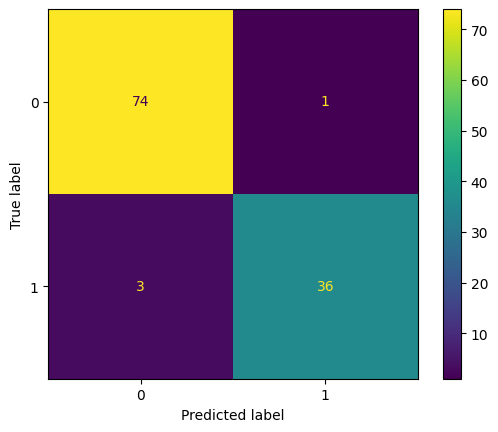

In [72]:
## Prep: switch to evaluation mode
model.eval()

with torch.no_grad(): # temporarily disable gradient calculation 

    ## Intialize some variables 
    correct = 0
    total = 0
    all_predictions = []  # To store predictions for confusion matrix
    all_labels = []       # To store true labels for confusion matrix

    ## Iterate over test data
    for x_batch, y_batch in DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=32):
        outputs = model(x_batch) # forward pass
        _, predicted = torch.max(outputs, 1)  # Get predicted classes
        total += y_batch.size(0) # update accuracy metrics 
        correct += (predicted == y_batch).sum().item()

        # Collect predictions and labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

## Calculate accuracy
accuracy = correct / total * 100
print(f'Test Accuracy: {accuracy:.2f}%')

## Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
ConfusionMatrixDisplay(cm).plot()


## 5. Understand model better: permutation feature importance

Goal
- Assess the importance of each feature by measuring how much the model's performance drops when the values of that feature are randomly shuffeled.
- A significant drop indicates the model relies heavily on that feature. 

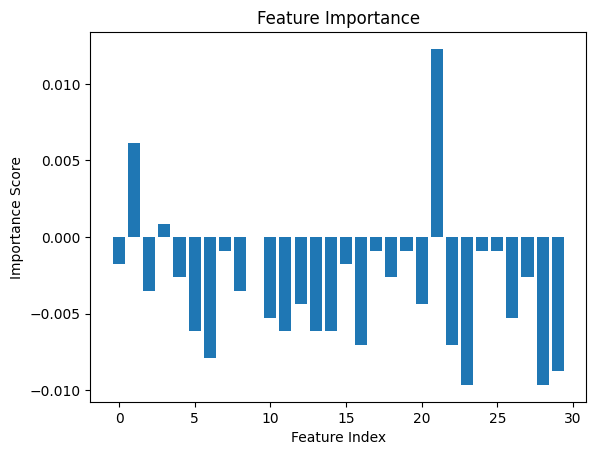

In [77]:
# Feature oriented analysis 

## Define the permutation importance function 
def custom_permutation_importance(model, X, y, metric, n_repeats=10):

    # Helper function to calculate accuracy
    def compute_accuracy(model, X, y):
        model.eval() # switch to evaluation mode 
        with torch.no_grad(): # Disable gradient computation 
            X_tensor = torch.tensor(X, dtype=torch.float32)
            y_tensor = torch.tensor(y, dtype=torch.long)
            outputs = model(X_tensor)
            _, predictions = torch.max(outputs, 1)
            return (predictions.numpy() == y).mean()

    # Base accuracy: computes performance before shuffling feature 
    baseline_score = compute_accuracy(model, X, y)

    importances = np.zeros(X.shape[1])  # One score for each feature

    ## Loop over each feature
    for col in range(X.shape[1]):  
        permuted_scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, col])  # Permutes one feature while leaving others unchanged 
            permuted_score = compute_accuracy(model, X_permuted, y) # Evaluate model
            permuted_scores.append(baseline_score - permuted_score) # Measure the performance drop 
        importances[col] = np.mean(permuted_scores)

    return importances

## Compute permutation importance
X_test_np = X_test_tensor.cpu().numpy()
Y_test_np = Y_test_tensor.cpu().numpy()
importances = custom_permutation_importance(model, X_test_np, Y_test_np, accuracy_metric)

# Plot feature importance
plt.bar(range(len(importances)), importances)
plt.title("Feature Importance")
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.show()



In [81]:
feature_of_interest = df.columns[21]
correlation_with_target = df.corr()["diagnosis"][feature_of_interest]
print(f"Correlation with target: {correlation_with_target}")

Correlation with target: 0.7764537785950396
